# Phillies Quantitative Analyst Take-Home
### Author: Ryan Williams
### Date: 05/12/2025

**Language**: Julia 1.11+

This notebook addresses Question 11 of the assessment, where we are tasked with predicting each pitcher's 2024 strikeout percentage (K%) using their prior performance data.

We use a hierarchical Bayesian model implemented via `Turing.jl` to estimate future K% while accounting for player-level effects and uncertainty.


In [2]:
# Setup Julia environment for the k_model package
using Pkg
Pkg.activate("k_model_env")
Pkg.add([
    "CSV",
    "DataFrames",
    "StatsPlots",
    "Turing",
    "Random",
    "Distributions",
    "StatsBase",
    "CategoricalArrays",
    "MCMCChains"
])
Pkg.precompile()

  Activating project at `~/git/QuantAnalysisAssets/phillies_takehome/k_model_env`
   Resolving package versions...
  No Changes to `~/git/QuantAnalysisAssets/phillies_takehome/k_model_env/Project.toml`
  No Changes to `~/git/QuantAnalysisAssets/phillies_takehome/k_model_env/Manifest.toml`


In [3]:
# Load libraries
using CSV, DataFrames
using StatsPlots
using Turing
using Random, Distributions
using StatsBase
# using CategoricalArrays
using LinearAlgebra
using MCMCChains
Random.seed!(42)

TaskLocalRNG()

## Load and inspect data
We begin by loading `k.csv`, which contains:
- Player identifiers (MLBAMID, FanGraphs ID)
- Age and season
- Total Batters Faced (TBF) and Strikeout Percentage (K%)

In [ ]:
df = CSV.read("k.csv", DataFrame)
first(df, 5)

In [ ]:
describe(df)
# names(df)

## Preprocess Data
- We sort by season and player
- We compute lagged K% and TBF
- We exclude rows with missing historical data (e.g., rookies)

In [5]:
rename!(df, Symbol("K%") => :K)

Row,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K
,Int64,Int64,String31,String7,Int64,Int64,Int64,Float64
1,695243,31757,Mason Miller,OAK,25,2024,249,0.417671
2,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889
3,518585,7048,Fernando Cruz,CIN,34,2024,288,0.378472
4,623352,14212,Josh Hader,HOU,30,2024,278,0.377698
5,663574,19926,Tony Santillan,CIN,27,2024,122,0.377049
6,669093,22210,Jeremiah Estrada,SDP,25,2024,252,0.373016
7,547973,10233,Aroldis Chapman,PIT,36,2024,265,0.369811
8,671305,22533,Michel Otañez,OAK,26,2024,151,0.364238
9,489446,9073,Kirby Yates,TEX,37,2024,237,0.35865


In [6]:
# Sort the DataFrame to ensure proper ordering within each player group
sort!(df, [:MLBAMID, :Season])

# Initialize new columns with missing values
df[!, :K_prev] = Vector{Union{Missing, Float64}}(missing, nrow(df))
df[!, :TBF_prev] = Vector{Union{Missing, Int64}}(missing, nrow(df))

# Fill previous season's K% and TBF for each pitcher
for g in groupby(df, :MLBAMID)
    global_indices = findall(x -> x in g.MLBAMID, df.MLBAMID)
    for i in 2:nrow(g)
        curr_idx = global_indices[i]
        prev_idx = global_indices[i - 1]

        df[!, :K_prev][curr_idx] = df[!, :K][prev_idx]
        df[!, :TBF_prev][curr_idx] = df[!, :TBF][prev_idx]
    end
end

# Drop rows that don’t have lagged values (e.g. rookies or first-year records)
df_model = dropmissing(df, [:K_prev, :TBF_prev])

# Add derived features
df_model[!, :ΔK] = df_model.K .- df_model.K_prev
df_model[!, :is_relief] = df_model.TBF .< 200

1029-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

### Scatter Plot of Features

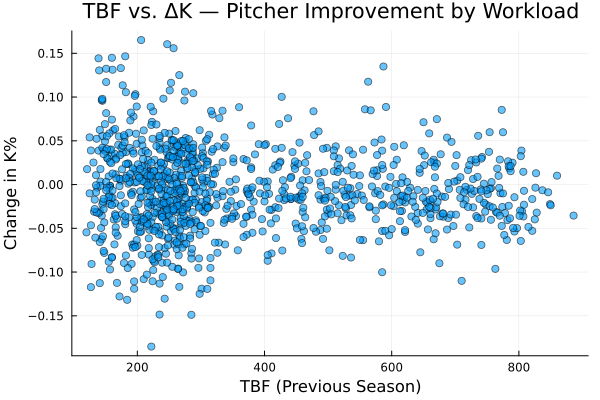

In [7]:
@df df_model scatter(
    :TBF_prev, :ΔK,
    xlabel = "TBF (Previous Season)",
    ylabel = "Change in K%",
    title = "TBF vs. ΔK — Pitcher Improvement by Workload",
    alpha = 0.6,
    legend = false
)

## Target and Features
- Target: K% for current season
- Features: prior K%, prior TBF, age

In [8]:
# Step 1: Create unique list of players
unique_players = unique(df_model.MLBAMID)

# Step 2: Create a lookup table mapping each player ID to an index
player_lookup = Dict(pid => i for (i, pid) in enumerate(unique_players))

# Step 3: Create player_index by mapping each row's MLBAMID to its index
player_index = [player_lookup[pid] for pid in df_model.MLBAMID]

# X features to use for now
X = select(df_model, [:K_prev, :TBF_prev, :Age]) |> Matrix

# y target
y = df_model.K |> collect

# player_index is now ready
# -> use it in: θ[player_index]

1029-element Vector{Float64}:
 0.17808219
 0.11363636
 0.12478632
 0.16357504
 0.21524664
 0.18686869
 0.32692308
 0.27659574
 0.28440367
 0.25342466
 ⋮
 0.22180451
 0.21398305
 0.17486339
 0.20353982
 0.24342105
 0.17445483
 0.2
 0.41767068
 0.19811321

## Turing Model Definition
We model K% as a function of prior stats, with player-level intercepts.

In [9]:
@model function k_predict_model(X, y, player_idx)
    N, D = size(X)
    n_players = maximum(player_idx)

    # μ = predicted K%
    # β = linear model coefficients
    # σ = residual stddev
    # θ = player-specific effect

    α ~ Normal(0, 1)
    β ~ MvNormal(D, 1.0)
    σ ~ Exponential(1.0)
    θ_player ~ filldist(Normal(0, 1), n_players)

    for i in 1:N
        μ = α + θ_player[player_idx[i]] + dot(X[i, :], β)
        y[i] ~ Normal(μ, σ)
    end
end

k_predict_model (generic function with 2 methods)

## Fit the Model

In [1]:
using Base.Threads
@show nthreads()

nthreads() = 4


4

In [ ]:
# Create model instance (assuming X, y, and player_index already defined)
model = k_predict_model(X, y, player_index)

# Use modern AD backend and parallel sampling
sampler = NUTS(adtype = AutoForwardDiff())

# Sample in parallel with 2 chains, 1000 samples each
chain = sample(model, sampler, MCMCThreads(), 1000, 2)

# Plot and save posterior trace
plot(chain)
savefig("figures/posterior_trace.png")

# Summary of posterior
describe(chain)

## Posterior Check (optional)